In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip uninstall -y tensorflow
!pip install tensorflow==1.15
!pip uninstall-y keras
!pip install keras==2.2.5

Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 3.8MB 51.3MB/s 
     |████████████████████████████████| 512kB 51.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9a7a8d37c446c84a5e5e9bd6114ba8f2dee964df5bd20ae51b1195118e14d575
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successf

In [3]:
import keras
print(keras.__version__) #should be 2.2.5
import tensorflow
print(tensorflow.__version__) #should be 1.15.0

Using TensorFlow backend.


2.2.5
1.15.0


In [4]:
import numpy as np
import os
from sklearn.externals import joblib

from numpy import array, arange, vstack, reshape, loadtxt, zeros
import pickle

import numpy as np
import tensorflow as tf

from keras import backend as K
# from keras.callbacks import ProgbarLogger, History, RemoteMonitor, LearningRateScheduler
# from keras.callbacks import CSVLogger, ReduceLROnPlateau, LambdaCallback
from keras.callbacks import TerminateOnNaN, EarlyStopping, ModelCheckpoint, TensorBoard, History, Callback
from keras.layers import Input, Lambda, concatenate, Dense
from keras.layers import Conv1D, MaxPooling1D, Layer, Add, Multiply
from keras.layers import UpSampling1D, Flatten, Reshape
from keras.layers import BatchNormalization, Dropout, Activation
from keras.losses import mse, mean_squared_error, binary_crossentropy, categorical_crossentropy
from keras.models import Model, Sequential
from keras.regularizers import l1_l2, l1

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def debug_message(message, end='\n'):
    print('[DEBUG] {}'.format(message), end=end)


def info_message(message, end='\n'):
    print('[INFO] {}'.format(message), end=end)


def warning_message(message, end='\n'):
    print('[WARNING] {}'.format(message), end=end)

class ExoplanetDataNew(object):
    exoplanet_filename = 'physical-spectra.pickle'
    # exoplanet_filename =
    # 'exoplanet_spectral_folded_database_normalized.joblib.save'
    default_train_file = '/content/gdrive/My Drive/exospec_data/'

    exoplanet_data_key = '1KIEDaGkDlcgZmL6t8rDlCp9PGN7glbWq'
    exoplanet_data_online = 'https://drive.google.com/open?id={}'
    exoplanet_data_online = exoplanet_data_online.format(exoplanet_data_key)

    def __init__(self, batch_size=128, test_size=0.20, train_file=None, 
                 normalize_spec=False, skip_features=5, use_all_data=True, rainout=False):
        ''' set skip_features to 0 to use `all` of the data
        '''
        np.random.seed(52770)
        if train_file is None:
            info_message('`default_train_file`: {}'.format(
                self.default_train_file))

            train_file = self.default_train_file
        elif not os.path.exists(train_file):
            warning_message('`train_file` does not exist. '
                            'Using default location')

            warning_message('`train_file`: {}'.format(train_file))
            warning_message('`default_train_file`: {}'.format(
                self.default_train_file))

            train_file = self.default_train_file

        exoplanet_filename = '{}/{}'.format(train_file,
                                            self.exoplanet_filename)

        if not os.path.exists(exoplanet_filename):
            raise Exception('{} does not exist; '
                            'give me data or give me death'.format(train_file))

        dataframe = pickle.load(open(exoplanet_filename, "rb"))
        spectra = np.stack(dataframe["spectrum"].to_numpy(), axis=0)[:,:,1]
        spectra = np.append(spectra, spectra[:, 4998:], axis=1)
        physics = np.stack(dataframe["physical"].to_numpy(), axis=0)

        idx_train, idx_test = train_test_split(np.arange(physics.shape[0]),
                                               test_size=test_size)

        if normalize_spec:
            for k, spec in enumerate(spectra):
                spectra[k] = spec - np.median(spec)

        y_train = physics[idx_train]  # features for decoder
        x_train = spectra[idx_train]  # labels for decoder

        y_test = physics[idx_test]  # features for decoder
        x_test = spectra[idx_test]  # labels for decoder

        n_samples_test = x_test.shape[0]
        n_samples_test = (n_samples_test // batch_size) * batch_size

        x_test = x_test[:n_samples_test]
        y_test = y_test[:n_samples_test]

        n_samples_train = x_train.shape[0]
        n_samples_train = (n_samples_train // batch_size) * batch_size

        x_train = x_train[:n_samples_train]
        y_train = y_train[:n_samples_train]

        y_minmax_sclr = MinMaxScaler()
        self.physics = physics
        self.spectra = spectra
        self.y_train = y_minmax_sclr.fit_transform(y_train)
        self.y_test = y_minmax_sclr.transform(y_test)

        x_rbst_sclr = RobustScaler(quantile_range=(0.001, 99.999))
        self.x_train = x_rbst_sclr.fit_transform(x_train)
        self.x_test = x_rbst_sclr.transform(x_test)


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def rmse(y_true, y_pred):
        # root mean squared error (rmse) for regression (only for Keras
        # tensors)

    # from keras import backend
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


def mse(y_true, y_pred):
        # mean squared error (mse) for regression  (only for Keras tensors)

    # from keras import K
    return K.mean(K.square(y_pred - y_true), axis=-1)


def r_square(y_true, y_pred):
        # coefficient of determination (R^2) for regression  (only for Keras
        # tensors)

    # from keras import backend as K
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from keras import backend as K

from keras.layers import Dense, Input, InputLayer
from keras.layers import Conv1D, Flatten, Lambda, Conv2DTranspose
from keras.layers import Reshape, UpSampling1D, Concatenate, Add
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import callbacks

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler

def Conv1DTranspose(filters, kernel_size,
                    activation='relu', strides=1,
                    padding='same', use_bias=False,
                    name=None):
    layer = Sequential()
    layer.add(UpSampling1D(strides))
    layer.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation=activation,
                     #dilation_rate=strides,
                     padding=padding,
                     name=name,
                     use_bias=use_bias))

    return layer

# def Conv1DTranspose(filters, kernel_size, activation='relu', strides=1, dilation_rate=1, padding='same', use_bias=False, name=None):
#     """
#         input_tensor: tensor, with the shape (batch_size, time_steps, dims)
#         filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
#         kernel_size: int, size of the convolution kernel
#         strides: int, convolution step size
#         padding: 'same' | 'valid'
#     """
#     layer = Sequential()
#     layer.add(Lambda(lambda x: K.expand_dims(x, axis=2)))
#     layer.add(Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), dilation_rate=dilation_rate,
#                         padding=padding, activation=activation, use_bias=use_bias, name=name))
#     layer.add(Lambda(lambda x: K.squeeze(x, axis=2)))
#     return layer

def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)

def make_keras_conv1d_vae_model(n_features, n_physical,
                                size_kernel_encoder, size_pool_encoder, size_filter_encoder, batchnorm_encoder,
                                # size_kernel_decoder, size_pool_decoder, size_filter_decoder,
                                size_dnn_encoder, l1_dnn_encoder,
                                # size_dnn_decoder,
                                size_latent, size_resnet,
                                use_bias=False):
    ''' VAE model = encoder + decoder'''
    # build encoder model
    vae_inputs = Input(shape=(n_features, 1), name='encoder_input')
    physical_inputs = Input(shape=(n_physical, ), name='physical_input')

    x = vae_inputs

    #ResNet
    for _ in range(max(size_resnet, 1)):
      x_shortcut = x
      for i in range(len(size_kernel_encoder)):
          x = Conv1D(filters=size_filter_encoder[i],
                    kernel_size=size_kernel_encoder[i],
                    activation='relu',
                    strides=size_pool_encoder[i],
                    padding='same',
                    use_bias=use_bias)(x)
          if batchnorm_encoder[i]:
            x = BatchNormalization()(x)
          
      #Skip Connection
      if(size_resnet > 0):
        x_shortcut = Conv1D(filters=size_filter_encoder[-1],
                      kernel_size=size_kernel_encoder[-1],
                      activation='relu',
                      strides=int(np.prod(size_pool_encoder)),
                      padding='same',
                      use_bias=use_bias)(x_shortcut)
        x = Add()([x, x_shortcut])
        x = Activation('relu')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)

    x = Concatenate()([x, physical_inputs])
    for i in range(len(size_dnn_encoder)):
      x = Dense(size_dnn_encoder[i], activation='relu', kernel_regularizer=l1(l1_dnn_encoder[i]))(x)
      #x = BatchNormalization()(x)

    z_mean = Dense(size_latent, name='z_mean')(x)
    z_log_var = Dense(size_latent, name='z_log_var')(x)
    #physical_output = Dense(n_physical, name='physical_output')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(size_latent, ),
               name='z')([z_mean, z_log_var])
    # z = Concatenate()([z, physical_output])

    # instantiate encoder model
    encoder = Model([vae_inputs, physical_inputs], [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    size_filter_decoder = size_filter_encoder[::-1]
    size_kernel_decoder = size_kernel_encoder[::-1]
    size_pool_decoder = size_pool_encoder[::-1]
    size_dnn_encoder = size_dnn_encoder[::-1]
    batchnorm_encoder = batchnorm_encoder[::-1]
    l1_dnn_encoder = l1_dnn_encoder[::-1]

    # build decoder model
    latent_input = Input(shape=(size_latent,), name='z_sampling')
    # physical_inputs = Input(shape=(n_physical, ), name='physical_input')
    x = Concatenate()([latent_input, physical_inputs])

    for i in range(len(size_dnn_encoder)):
      x = Dense(size_dnn_encoder[i], activation='relu', kernel_regularizer=l1(l1_dnn_encoder[i]))(x)
      #x = BatchNormalization()(x)
      
    x = Dense(shape[1] * shape[2], activation='relu')(x)
    x = Reshape((shape[1], shape[2]))(x)

    #ResNet
    for _ in range(max(size_resnet, 1)):
      x_shortcut = x
      for i in range(len(size_kernel_decoder)):
          x = Conv1DTranspose(filters=size_filter_decoder[i],
                              kernel_size=size_kernel_decoder[i],
                              activation='relu',
                              strides=size_pool_decoder[i],
                              #dilation_rate=size_pool_encoder[i],
                              padding='same',
                              use_bias=use_bias)(x)
          if batchnorm_encoder[i]:
            x = BatchNormalization()(x)

      #Skip Connection
      if(size_resnet > 0):
        x_shortcut = Conv1DTranspose(filters=size_filter_decoder[-1],
                      kernel_size=size_kernel_decoder[-1],
                      activation='relu',
                      strides=int(np.prod(size_pool_decoder)),
                      padding='same',
                      use_bias=use_bias)(x_shortcut)
        x = Add()([x, x_shortcut])
        x = Activation('relu')(x)

    outputs = Conv1DTranspose(filters=1,
                              kernel_size=3,
                              activation='linear',
                              padding='same',
                              name='decoder_output',
                              use_bias=use_bias)(x)
    
    outputs = crop(1, 0, n_features)(outputs)

    # instantiate decoder model
    decoder = Model([latent_input, physical_inputs], outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder([encoder([vae_inputs, physical_inputs])[2], physical_inputs])
    vae = Model([vae_inputs, physical_inputs], outputs, name='vae')

    return vae

def make_reconstruction_loss(vae, n_features):
    [vae_inputs, physical_inputs] = vae.inputs
    outputs = vae.outputs

    reconstruction_loss = mse(K.flatten(vae_inputs), K.flatten(outputs))
    reconstruction_loss *= n_features

    return K.mean(reconstruction_loss)

def make_kl_loss(vae):
    _, _, encoder, decoder = vae.layers
    z_mean, z_log_var, z = encoder.outputs

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    return K.mean(kl_loss)

def r2_metric(vae):
  [vae_inputs, physical_inputs] = vae.inputs
  outputs = vae.outputs
  def r_squared():
    SS_res =  K.sum(K.square(vae_inputs - outputs)) 
    SS_tot = K.sum(K.square(vae_inputs - K.mean(vae_inputs))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

  return r_squared

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [6]:
from sklearn.model_selection import train_test_split

np.random.seed(52770)
data = ExoplanetDataNew(batch_size=256, normalize_spec=False)
# Batch is hard coded from the GA, because I don't want to load the data for every chromosome

x_train = data.x_train
y_train = data.y_train
x_test, x_val, y_test, y_val = train_test_split(data.x_test, data.y_test, test_size=0.5, random_state=42)

_, n_features = x_train.shape
_, n_physical = y_train.shape
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))
x_val = x_val.reshape(x_val.shape + (1,))


[INFO] `default_train_file`: /content/gdrive/My Drive/exospec_data/


In [0]:
import requests
import json
import time

base_url = 'laudeepgenerativegenetics.pythonanywhere.com'

while True:
  info_message('Grabbing Untrained Chromosome')
  chromosome = requests.get(url="http://{}/GetUnTrainedChrom".format(base_url))

  if(chromosome != None and chromosome.text == "0"):
    info_message("No more Chromosomes to train")
    time.sleep(30)
  elif(chromosome != None):
    try:
      print('Accessing Params from Untrained Chromosome')
      params = chromosome.json()
    except:
      print('Error Parsing Chromosome')
      continue

    print(params)
    batch_size = params["batch_size"]
    num_epochs = params["num_epochs"]

    size_dnn_encoder = np.array(json.loads(params["size_dnn_encoder"]))
    l1_dnn_encoder = np.array(json.loads(params["l1_dnn_encoder"]))
    l1_dnn_encoder = 10**l1_dnn_encoder*0.001 * (l1_dnn_encoder != 0)
    # size_dnn_decoder = np.array(json.loads(params["size_dnn_decoder"]))
    size_latent = params["size_latent"]
    size_resnet = params["size_resnet"]

    size_kernel_encoder = np.array(json.loads(params["size_kernel_encoder"]))
    size_kernel_encoder = size_kernel_encoder*2 +1
    size_pool_encoder = np.array(json.loads(params["size_pool_encoder"]))
    size_pool_encoder = size_pool_encoder+1
    size_filter_encoder = np.array(json.loads(params["size_filter_encoder"]))
    batchnorm_encoder = np.array(json.loads(params["batchnorm_encoder"]))
    batchnorm_encoder = (batchnorm_encoder != 0)

    size_kernel_encoder = size_kernel_encoder.tolist()
    size_pool_encoder = size_pool_encoder.tolist()
    size_filter_encoder = size_filter_encoder.tolist()
    size_dnn_encoder = size_dnn_encoder.tolist()
    
    # size_kernel_decoder = np.array(json.loads(params["size_kernel_decoder"]))*2 +1
    # size_pool_decoder = np.array(json.loads(params["size_pool_decoder"]))+1
    # size_filter_decoder = np.array(json.loads(params["size_filter_decoder"]))

    vae = make_keras_conv1d_vae_model(n_features, n_physical,
                                size_kernel_encoder, size_pool_encoder, size_filter_encoder, batchnorm_encoder,
                                # size_kernel_decoder, size_pool_decoder, size_filter_decoder,
                                size_dnn_encoder, l1_dnn_encoder,
                                # size_dnn_decoder,
                                size_latent, size_resnet)

    vae.add_loss(make_kl_loss(vae))
    vae.add_loss(make_reconstruction_loss(vae, n_features))

    vae.compile(optimizer='adam', matrics=[r2_metric(vae)])

    vae.metrics_tensors.append(make_kl_loss(vae))
    vae.metrics_names.append("kl_loss")

    vae.metrics_tensors.append(make_reconstruction_loss(vae, n_features))
    vae.metrics_names.append("reconstruction_loss")

    vae.summary()

    callbacks_ = []
    callbacks_.append(callbacks.TerminateOnNaN())
    callbacks_.append(callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True))
    
    history = vae.fit([x_train, y_train],
                  epochs=num_epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=callbacks_)

    params["train_kl_loss"] = history.history["kl_loss"][np.argmin(history.history["kl_loss"])]
    params["train_reconstruction_loss"] = history.history["reconstruction_loss"][np.argmin(history.history["reconstruction_loss"])]
    params["test_kl_loss"] = history.history["val_kl_loss"][np.argmin(history.history["val_kl_loss"])]
    params["test_reconstruction_loss"] = history.history["val_reconstruction_loss"][np.argmin(history.history["val_reconstruction_loss"])]

    y_pred = vae.predict([x_test, y_test])
    r2_test = r2_score(x_test[:, :, 0], y_pred[:, :, 0])
    rmse_test = np.sqrt(mean_squared_error(x_test[:, :, 0], y_pred[:, :, 0]))
    print(f'Test R2  : {r2_test}')
    print(f'Test RMSE: {rmse_test}')
    params["fitness"] = r2_test

    y_pred = vae.predict([x_val, y_val])
    r2_val = r2_score(x_val[:, :, 0], y_pred[:, :, 0])
    rmse_val = np.sqrt(mean_squared_error(x_val[:, :, 0], y_pred[:, :, 0]))
    print(f'Validation R2  : {r2_val}')
    print(f'Validation RMSE: {rmse_val}')
    params["val_fitness"] = r2_val

    params["date_trained"] = int(time.time())

    del vae
    tf.reset_default_graph()
    K.clear_session()
    
    sent = False
    while(not sent):
      try:
        resp = requests.get(
            url="http://{}/AddChrom".format(base_url),
            params=params)
        sent = (resp.text == "1")
      except:
        sent = False

[INFO] Grabbing Untrained Chromosome
Accessing Params from Untrained Chromosome
{'batch_size': 256, 'batchnorm_encoder': '[1]', 'chroms_per_loop': 10, 'cross_prob': 0.7, 'date_created': 1590923223, 'date_taken': 1590924031, 'date_trained': -1, 'fitness': -1.0, 'id': 4, 'info': '', 'l1_dnn_encoder': '[0, 1]', 'mutate_prob': 0.1, 'num_cnn_encoder': 1, 'num_dnn_encoder': 2, 'num_epochs': 150, 'population_size': 100, 'size_dnn_encoder': '[2, 1]', 'size_filter_encoder': '[138]', 'size_kernel_encoder': '[4]', 'size_latent': 3, 'size_pool_encoder': '[1]', 'size_resnet': 1, 'test_kl_loss': -1.0, 'test_reconstruction_loss': -1.0, 'train_kl_loss': -1.0, 'train_reconstruction_loss': -1.0, 'val_fitness': -1.0}

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5000, 1)      0                      

In [7]:
import json
import time

params = {"batch_size":256,"num_cnn_encoder":3,"num_dnn_encoder":1,"num_epochs":150,"size_dnn_encoder":"[100]","size_filter_encoder":"[10, 50, 100]","size_kernel_encoder":"[5, 3, 2]", "size_latent":5, "size_pool_encoder":"[0, 1, 2]"}

print(params)
batch_size = params["batch_size"]
num_epochs = params["num_epochs"]

size_dnn_encoder = np.array(json.loads(params["size_dnn_encoder"]))
# size_dnn_decoder = np.array(json.loads(params["size_dnn_decoder"]))
size_latent = params["size_latent"]

size_kernel_encoder = np.array(json.loads(params["size_kernel_encoder"]))*2 +1
size_pool_encoder = np.array(json.loads(params["size_pool_encoder"]))+1
size_filter_encoder = np.array(json.loads(params["size_filter_encoder"]))

size_kernel_encoder = size_kernel_encoder.tolist()
size_pool_encoder = size_pool_encoder.tolist()
size_filter_encoder = size_filter_encoder.tolist()
size_dnn_encoder = size_dnn_encoder.tolist()

# size_kernel_decoder = np.array(json.loads(params["size_kernel_decoder"]))*2 +1
# size_pool_decoder = np.array(json.loads(params["size_pool_decoder"]))+1
# size_filter_decoder = np.array(json.loads(params["size_filter_decoder"]))

vae = make_keras_conv1d_vae_model(n_features, n_physical,
                                size_kernel_encoder, size_pool_encoder, size_filter_encoder,
                                # size_kernel_decoder, size_pool_decoder, size_filter_decoder,
                                size_dnn_encoder, 
                                # size_dnn_decoder,
                                size_latent)

vae.add_loss(make_kl_loss(vae))
vae.add_loss(make_reconstruction_loss(vae, n_features))

vae.compile(optimizer='adam')

vae.metrics_tensors.append(make_kl_loss(vae))
vae.metrics_names.append("kl_loss")

vae.metrics_tensors.append(make_reconstruction_loss(vae, n_features))
vae.metrics_names.append("reconstruction_loss")

vae.summary()

callbacks_ = []
callbacks_.append(callbacks.TerminateOnNaN())
callbacks_.append(callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True))

history = vae.fit([x_train, y_train],
              epochs=num_epochs,
              batch_size=batch_size,
              validation_split=0.2,
              callbacks=callbacks_)

params["train_kl_loss"] = history.history["kl_loss"][np.argmin(history.history["kl_loss"])]
params["train_reconstruction_loss"] = history.history["reconstruction_loss"][np.argmin(history.history["reconstruction_loss"])]
params["test_kl_loss"] = history.history["val_kl_loss"][np.argmin(history.history["val_kl_loss"])]
params["test_reconstruction_loss"] = history.history["val_reconstruction_loss"][np.argmin(history.history["val_reconstruction_loss"])]

y_pred = vae.predict([x_test, y_test])
r2_test = r2_score(x_test[:, :, 0], y_pred[:, :, 0])
rmse_test = np.sqrt(mean_squared_error(x_test[:, :, 0], y_pred[:, :, 0]))
print(f'Test R2  : {r2_test}')
print(f'Test RMSE: {rmse_test}')
params["fitness"] = r2_test

y_pred = vae.predict([x_val, y_val])
r2_val = r2_score(x_val[:, :, 0], y_pred[:, :, 0])
rmse_val = np.sqrt(mean_squared_error(x_val[:, :, 0], y_pred[:, :, 0]))
print(f'Validation R2  : {r2_val}')
print(f'Validation RMSE: {rmse_val}')
params["val_fitness"] = r2_val

params["date_trained"] = int(time.time())

{'batch_size': 256, 'num_cnn_encoder': 3, 'num_dnn_encoder': 1, 'num_epochs': 150, 'size_dnn_encoder': '[100]', 'size_filter_encoder': '[10, 50, 100]', 'size_kernel_encoder': '[5, 3, 2]', 'size_latent': 5, 'size_pool_encoder': '[0, 1, 2]'}




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5000, 10)     110         encoder_input[0][0]              
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2500, 50)     3500        conv1d_1[0][0]                   
______________________________________________

In [15]:
 _, _, encoder, decoder = vae.layers
latent_values = np.random.normal(size=(len(x_test),size_latent))
y_pred = decoder.predict([latent_values, y_test])
r2_test = r2_score(x_test[:, :, 0], y_pred[:, :, 0])
print(r2_test)

0.9991687469075167


In [0]:
vae.save_weights('/content/gdrive/My Drive/exospec_data/model_checkpoints/vae_cnn.h5');

In [8]:
vae.load_weights('/content/gdrive/My Drive/exospec_data/model_checkpoints/vae_cnn.h5');

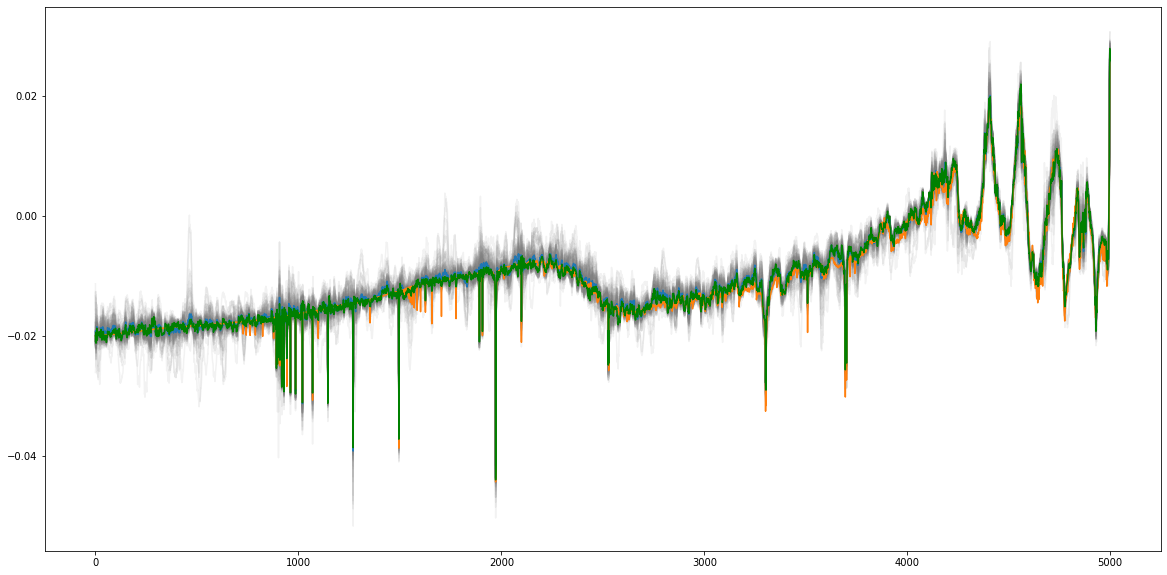

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10));

n_trials = 100
idx_spec = 42

n_waves = x_test.shape[1]
y_pred_mean = np.zeros(n_waves)
for _ in range(n_trials):
    latent_values = np.random.normal(size=(1,size_latent))
    y_pred = decoder.predict([latent_values*10, y_test[:,None][idx_spec]])
    y_pred_mean += y_pred.flatten()
    plt.plot(y_pred.flatten(), alpha=0.1, color='grey')


y_pred_mean /= n_trials
plt.plot(y_pred_mean)
plt.plot(x_test[idx_spec])

latent_values = np.zeros((1,size_latent))
y_pred = decoder.predict([latent_values, y_test[:,None][idx_spec]])
plt.plot(y_pred.flatten(), color='green')